In [1]:
import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

login-2.fram.sigma2.no
fram detected


In [2]:
import os
import pandas as pd

from datetime import date

import xarray as xr
import numpy as np
from glob import glob
import datetime
import re

In [3]:
import src.utils.load_config as load_config

login-2.fram.sigma2.no
fram detected


In [4]:
import yaml
user = yaml.load(open('../config/data_proc_demo.yaml'), Loader=yaml.FullLoader)['user']

In [5]:
# file_config = '../config/data_proc_demo.yaml'
file_config = '../config/data_proc_full.yaml'
# Path to template file
file_template = '../config/template_name.yaml'

# template = yaml.load(open(file_template),Loader=yaml.FullLoader)
load_config.update_config(file_config, verbose=True)
nosit_dir, withsit_dir, _, forcing_bdir, pca_dir, res_dir, fig_dir, ml_dir = load_config.load_filename(file_config)
timeofday, target_field, forcing_fields, covar_fields, lim_idm, lim_jdm, n_comp = load_config.load_config_params(file_config)

PCA results in: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629
Config file updated (pca_dir): ../config/data_proc_full.yaml
Config file updated: ../config/data_proc_full.yaml
Results in: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_8F_rw21d_N4444_H1333_Hn0000_sithick_noname_220927-094206
Folder created

Config file updated.


In [6]:
# Pseudo-code

# open file

# check grid ERA5

# check grid TOPAZ

# determine closest point of ERA5 on TOPAZ grid


# retrieve points for each time step (6h) looping on yearly .nc
# for 2010-2017 at first


# save to pickle file

## Get only interesting years and var

In [7]:
datadir = '/cluster/projects/nn9481k/ERA5_6h/' # os.path.join(rootdir,user+f'/Jiping/dailyforcing_2014_2017')
pkldir = os.path.join(rootdir,user+f'/forcings_full/ERA5_cTOPAZ/')  # f'Julien/forcings'

In [8]:
years=[2010, 2017]
# years=[1991,2020]

var = '2T'

In [9]:
allfiles = sorted(glob(os.path.join(datadir,f'6h.{var}*.nc')))
listyear = [os.path.basename(name)[6:-3] for name in allfiles]
listfile=[]

# selection corresponding years
for idx, name in enumerate(listyear):
    if int(name)>=years[0] and int(name)<=years[-1]:
        listfile += [allfiles[idx]]
    

In [10]:
print('List of forcings')
print(listfile)

List of forcings
['/cluster/projects/nn9481k/ERA5_6h/6h.2T_2010.nc', '/cluster/projects/nn9481k/ERA5_6h/6h.2T_2011.nc', '/cluster/projects/nn9481k/ERA5_6h/6h.2T_2012.nc', '/cluster/projects/nn9481k/ERA5_6h/6h.2T_2013.nc', '/cluster/projects/nn9481k/ERA5_6h/6h.2T_2014.nc', '/cluster/projects/nn9481k/ERA5_6h/6h.2T_2015.nc', '/cluster/projects/nn9481k/ERA5_6h/6h.2T_2016.nc', '/cluster/projects/nn9481k/ERA5_6h/6h.2T_2017.nc']


## Grid ERA5

Create yearly file otherwise to heavy (process killed)

In [ ]:
# for idx_yr, yrfl in enumerate(listfile):

In [11]:
nc = xr.open_mfdataset(listfile[0], combine='nested', concat_dim='time')
# nc = xr.open_mfdataset(yrfl, combine='nested', concat_dim='time')


In [12]:
nc[var]

<xarray.DataArray '2T' (time: 2920, latitude: 721, longitude: 1440)>
dask.array<concatenate, shape=(2920, 721, 1440), dtype=float32, chunksize=(1460, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 ... 2011-12-31T18:00:00
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Attributes:
    long_name:  2 metre temperature
    units:      K
    table:      128
    code:       167

In [13]:
nc['latitude'];

In [14]:
nc['longitude'];

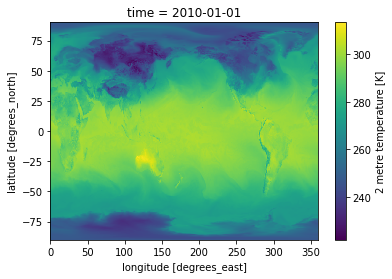

In [15]:
nc[var][0].plot()

## Grid TOPAZ

In [16]:
template = {}

In [17]:
template['dailync_full'] = '{year:04d}{month:02d}{day:02d}_dm-12km-NERSC-MODEL-TOPAZ4B-ARC-RAN.fv2.0.nc'

In [18]:
withsit_dir = '/nird/projects/nird/NS2993K/Leo/Jiping_full/TP4b_with'

In [19]:
nc1 = xr.open_dataset(os.path.join(rootdir, withsit_dir, template['dailync_full'].format(year=2010, month=1, day=1)))

In [20]:
# new area for the new version of TOPAZ
lim_jdm = (300, 629)
lim_idm = (100, 550)

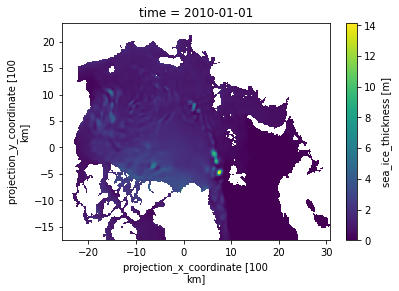

In [21]:
# just to check area to consider
nc_sel = nc1['sithick'].isel(y=slice(*lim_jdm), x=slice(*lim_idm))
nc_sel[0].plot()

In [22]:
nc1['latitude'].y

<xarray.DataArray 'y' (y: 881)>
array([-55.   , -54.875, -54.75 , ...,  54.75 ,  54.875,  55.   ],
      dtype=float32)
Coordinates:
  * y        (y) float32 -55.0 -54.88 -54.75 -54.62 ... 54.62 54.75 54.88 55.0
Attributes:
    standard_name:  projection_y_coordinate
    axis:           Y
    units:          100  km

In [23]:
tlat = nc1['latitude'].isel(y=slice(*lim_jdm), x=slice(*lim_idm))

In [24]:
tlon = nc1['longitude'].isel(y=slice(*lim_jdm), x=slice(*lim_idm))

## Determine closest point of ERA5 on TOPAZ grid

In [25]:
from src.utils import long_trans

In [26]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [27]:
print(f'Lon before:  {tlon.data[0,0]}')
print(f'Lon after:  {long_trans.l180_to_360(tlon.data[0,0])}')

Lon before:  -100.5391845703125
Lon after:  259.4608154296875


-----

In [28]:
tlat1d = tlat.stack(z=('y','x'))

In [29]:
tlon1d = tlon.stack(z=('y','x'))

In [30]:
tlon1d_180 = long_trans.l180_to_360(tlon1d.data)

In [31]:
tlat1d.data

array([62.743996, 62.831387, 62.91867 , ..., 56.490562, 56.409084,
       56.327522], dtype=float32)

In [32]:
close_lat = [find_nearest(nc['latitude'].data, lat) for lat in tlat1d.data]

In [33]:
close_lon = [find_nearest(nc['longitude'].data, lon) for lon in tlon1d_180.data]

In [34]:
lat_idx = [item[1] for item in close_lat]

In [35]:
lat_nc = [item[0] for item in close_lat]

In [36]:
lon_idx = [item[1] for item in close_lon]

In [37]:
lon_nc = [item[0] for item in close_lon]

# retrieve points for each time step (6h)
looping on yearly .nc
for 2010-2017 at first

In [38]:
len(lat_idx)

148050

In [39]:
# converting to numpy and get the indexes is the most efficient and fast

In [40]:
ds = nc[var].to_numpy()

In [41]:
ds_sel = ds[:, lat_idx, lon_idx]

In [42]:
ds3 = ds_sel.reshape(ds_sel.shape[0], 329, 450)

-----

# save to pickle file

In [43]:
dttm = pd.to_datetime(nc['time'].to_numpy())

-----

In [44]:
pkldir

'/nird/projects/nird/NS2993K/Leo/forcings_full'

In [45]:
nc['time'];

----------

In [46]:
to_save = xr.Dataset(data_vars={f'{var}':(['time','y','x'], ds3, 
                                               {'name':nc[f'{var}'].name, 
                                                'long_name':nc[f'{var}'].long_name,
                                                'units':nc[f'{var}'].units,
                                                'jdm':lim_jdm,
                                                'idm':lim_idm}),}, 
                      coords=dict(time=nc['time'],
                                longitude=tlon,
                                latitude=tlat),
                      attrs=dict(
                          description=f'Truncated ERA5 forcing fields on period {years[0]}-{years[-1]} over the Arctic',
                          author='Leo Edel, Nersc',
                          project='TARDIS',
                          date=f'{date.today()}')
                      )

In [48]:
# save era5 selection to .nc

filename_nc = os.path.join(pkldir,f'{var}_{years[0]}_{years[-1]}_ERA5_coloc_TOPAZ.nc')
# filename_nc = os.path.join(pkldir,f'{var}_{idx_yr}_ERA5_coloc_TOPAZ.nc')

to_save.to_netcdf(filename_nc)

----------

----------

# Load .nc

In [ ]:
# filename_nc = os.path.join(pkldir,f'{var}_{years[0]}_{years[-1]}.nc')

In [ ]:
# ncl = xr.open_mfdataset(filename_nc, combine='nested', concat_dim='time')


In [ ]:
# ncl[var][0].plot()